In [1]:
from typing import Dict, Any, Tuple, List

import torch
import torch.nn as nn
from configs import config
from torch.nn import functional as F
from model import UNetSparse, GeometryHeadSparse, ClassificationHeadSparse
import MinkowskiEngine as Me
from model import MyModel
from semantic_kitti_dataset import SemanticKITTIDataset, Merge
from tqdm import tqdm
import numpy as np
import time
from structures import collect
from evaluation import iouEval
import k3d
import numpy as np
from utils import plot_3d_voxels, plot_2d_input, plot_bev
from model import UNet

device = torch.device("cuda:0")

shapes = {"256": torch.Size([1, 1, 256, 256, 32]), "128": torch.Size([1, 1, 128, 128, 16]), "64": torch.Size([1, 1, 64, 64, 8])}

%load_ext autoreload
%autoreload 2


## Dataloader

In [9]:
config.GENERAL.NUM_SAMPLES_OVERFIT = 2
config.GENERAL.OVERFIT = False
config.TRAIN.AUGMENT = True
config.TRAIN.NOISE_LEVEL = 0.0
config.TRAIN.NUM_WORKERS = 0
config.TRAIN.BATCH_SIZE = 1

train_dataset = SemanticKITTIDataset(config, "valid",do_overfit=config.GENERAL.OVERFIT, num_samples_overfit=config.GENERAL.NUM_SAMPLES_OVERFIT, augment=config.TRAIN.AUGMENT)
train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN.BATCH_SIZE,
        collate_fn=Merge,
        num_workers=config.TRAIN.NUM_WORKERS,
        pin_memory=True,
        shuffle=False,
        drop_last=True,
        worker_init_fn=lambda x: np.random.seed(x + int(time.time()))
    )

RuntimeError: Missing data for label_128

In [8]:
print(len(train_data_loader))

4541


In [3]:
batch = next(iter(train_data_loader))
_, complet_inputs, _, _ = batch


## Visualize labels

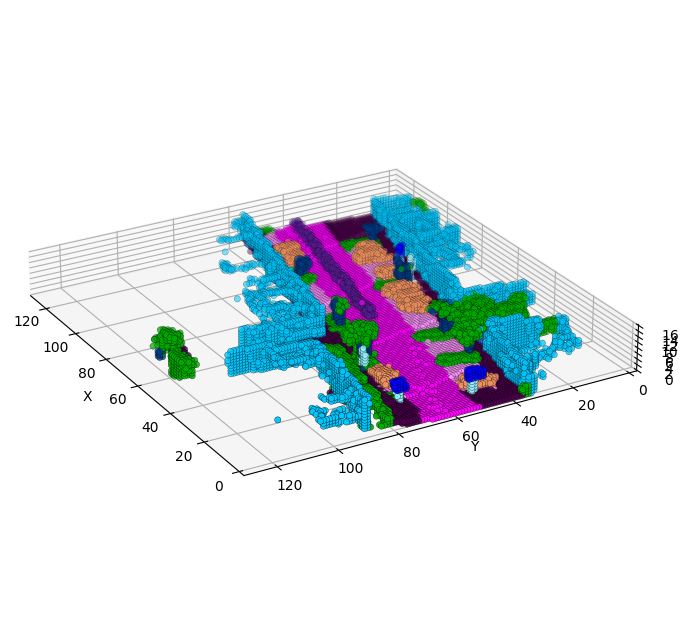

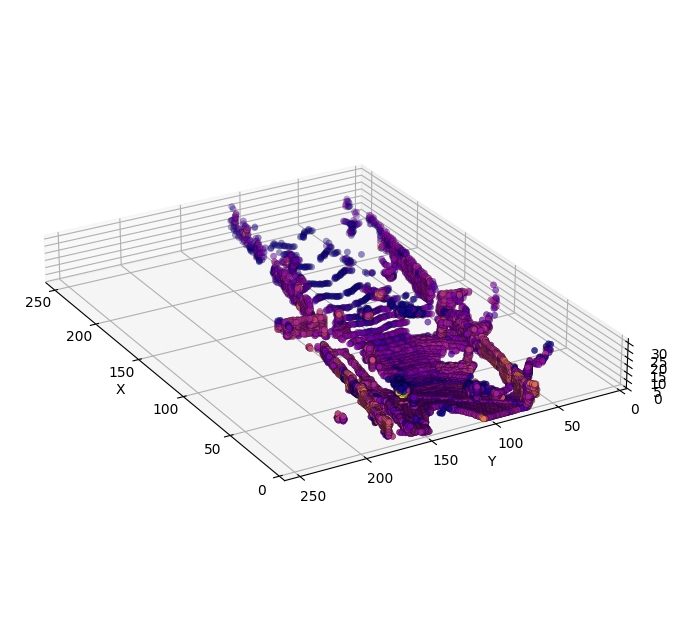

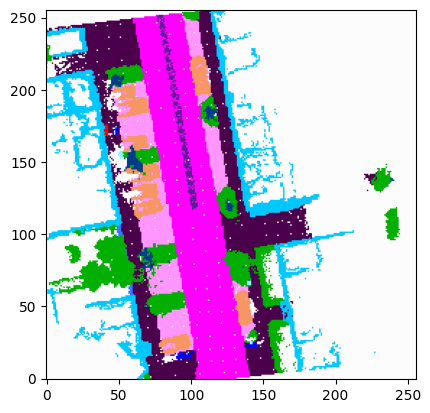

In [4]:
level = "128"
input2d = collect(complet_inputs, "input2d")
bev_labels = collect(complet_inputs, "bev_labels")

gt_labels = collect(complet_inputs, "complet_labels_{}".format(level))
gt_labels = np.uint32(gt_labels.detach().cpu().numpy())
invalid = gt_labels==255
gt_labels[gt_labels==255] = 0
coords = collect(complet_inputs, "complet_coords").squeeze()
complet_features = collect(complet_inputs, "complet_features")

coords_np = coords[:,:].detach().cpu().numpy()
coords_np = coords_np.astype(int)
voxels = np.zeros((1,256,256,32))
# voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=np.int32(complet_features.detach().cpu().numpy()[0]*10.0)
voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2],coords_np[:,3]]=(np.uint8(complet_features[0].detach().cpu().numpy()*126.0)+1.0)
plot_3d_voxels(gt_labels[0], level)
plot_3d_voxels(voxels[0], level, input=True)
# plot_2d_input(input2d[0])
plot_bev(bev_labels[0])
# plot_3d_voxels(gt_labels[1], level)
# plot_3d_voxels(voxels[1], level,input=True)


## 2D UNet model

In [5]:
unet_model = UNet(n_channels=7, n_classes=config.SEGMENTATION.NUM_CLASSES, num_output_features=config.MODEL.NUM_OUTPUT_CHANNELS)
unet_model.eval()
unet_model.cuda()
start = time.time()
output, f1, f2, f3, f4, f5 = unet_model.inference(input2d)
end = time.time()
print(end-start)
print(output.shape)
print(torch.unique(output))

0.03847670555114746
torch.Size([1, 256, 256])
tensor([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19],
       device='cuda:0')


In [6]:
from utils import labels_to_cmap2d
output_color = labels_to_cmap2d(output)
print(output_color.shape)

(1, 3, 256, 256)


In [7]:
print(output.shape)
print(f1.shape)
print(f2.shape)
print(f3.shape)
print(f4.shape)
print(f5.shape)
features2D = [f2.detach(),f3.detach(),f4.detach(),f5.detach()]

torch.Size([1, 256, 256])
torch.Size([1, 16, 256, 256])
torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])


In [8]:
# import matplotlib.pyplot as plt
# for i in range(7):
#     mean_feature = features2d[i,:,:].cpu().numpy()
#     invalid = mean_feature==255
#     mean_feature = mean_feature - np.amin(mean_feature)
#     mean_feature = mean_feature/np.amax(mean_feature)
#     mean_feature[invalid]=0
#     plt.imshow(mean_feature)
#     plt.show()

## Model

In [9]:
torch.cuda.empty_cache()

config.MODEL.GEN_64_WEIGHT = 0.0
config.GENERAL.LEVEL = "256"
config.MODEL.UNET2D = True
model = MyModel(num_output_channels=config.MODEL.NUM_OUTPUT_CHANNELS, unet_features=config.MODEL.UNET_FEATURES)
# model.load_state_dict(torch.load("experiments/194/modelFULL-57.pth")) # Full Training
model = model.to(device)
model.eval()
compl_labelweights = torch.Tensor(train_dataset.compl_labelweights).cuda()
results, _ = model(complet_inputs, compl_labelweights, features2D=features2D)
print(results.keys())

coords:  torch.Size([11269, 4])
features:  torch.Size([11269, 1])
dict_keys(['occupancy_64', 'semantic_64', 'semantic2D_64', 'disc_64', 'gen_64', 'occupancy_128', 'semantic_128', 'occupancy_256'])


/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/MinkowskiSparseTensor.py:537: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  coords = coords // tensor_stride
/usr/src/app/semantic-scene-completion/model/my_model.py:282: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // p

In [11]:
print(5 in [1,2,3,4,5])

True


## Calculate 2D input tensor

In [ ]:
import time

feature_voxels = torch.zeros((1,256,256,32))
feature_voxels[:,coords2[:,0],coords2[:,1],coords2[:,2]] = complet_features.cpu()


def get_2d_features(features, locs):
    locations_z = torch.ones_like(features)*-1.0
    locations_z[:,locs[:,0],locs[:,1],locs[:,2]] = locs[:,2].float()
    max_locs_voxels = torch.max(locations_z.float(),3)[0]
    max_locs_voxels[max_locs_voxels==-1] = 255
    max_locs_voxels[max_locs_voxels!=255] = max_locs_voxels[max_locs_voxels!=255]/32.0 - 0.5

    locations_z = torch.ones_like(features)*255.0
    locations_z[:,locs[:,0],locs[:,1],locs[:,2]] = locs[:,2].float()
    min_locs_voxels = torch.min(locations_z.float(),3)[0]
    min_locs_voxels[min_locs_voxels!=255]  = min_locs_voxels[min_locs_voxels!=255]/32.0 -0.5

    locations_z = torch.full(features.shape, torch.nan)
    locations_z[:,locs[:,0],locs[:,1],locs[:,2]] = locs[:,2].float()
    mean_locs_voxels = torch.nanmean(locations_z.float(),3)
    mean_locs_voxels = mean_locs_voxels/6.0 - 0.5
    mean_locs_voxels = torch.nan_to_num(mean_locs_voxels,255)

    feature_voxels_cpy = torch.ones_like(features)*-255
    feature_voxels_cpy[:,locs[:,0],locs[:,1],locs[:,2]] = features[:,locs[:,0],locs[:,1],locs[:,2]]
    max_feature_voxels = torch.max(features,3)[0].float()
    max_feature_voxels[max_feature_voxels==-255] = 255
    # max_feature_voxels[max_feature_voxels!=255] = max_feature_voxels[max_feature_voxels!=255]/2.0 - 0.5

    feature_voxels_cpy = torch.ones_like(features)*255
    feature_voxels_cpy[:,locs[:,0],locs[:,1],locs[:,2]] = features[:,locs[:,0],locs[:,1],locs[:,2]]
    min_feature_voxels = torch.min(feature_voxels_cpy,3)[0].float()
    # min_feature_voxels[min_feature_voxels != 255] = min_feature_voxels[min_feature_voxels != 255]/1.0 - 0.5

    feature_voxels_cpy = torch.full(features.shape, torch.nan)
    feature_voxels_cpy[:,locs[:,0],locs[:,1],locs[:,2]] = features[:,locs[:,0],locs[:,1],locs[:,2]]
    mean_feature_voxels = torch.nanmean(features,3).float()
    mean_feature_voxels = mean_feature_voxels/0.7 - 0.5
    mean_feature_voxels = torch.nan_to_num(mean_feature_voxels,255)

    density_feature_voxels = torch.sum(torch.logical_not(torch.isnan(feature_voxels_cpy)),3).float()/16.0 - 0.5

    features2d = torch.cat([min_locs_voxels,max_locs_voxels,mean_locs_voxels,min_feature_voxels,
                            max_feature_voxels,mean_feature_voxels, density_feature_voxels])
    
    return features2d

start = time.time()
features2d = get_2d_features(feature_voxels, coords2)
end = time.time()

print(end-start)
print(features2d.shape)


In [12]:
level = "64"
print(results.keys())
occupancy_prediction = results['occupancy_{}'.format(level)]
semantic_prediction = results['semantic_labels_{}'.format(level)]
print("semantic_prediction: ", semantic_prediction.shape)
shape = shapes[level]
min_coordinate = torch.IntTensor([0, 0, 0]).to(device)

if level == "64":
    occupancy_prediction = occupancy_prediction[0,0].detach().cpu().numpy() > 0.5
    semantic_prediction = np.uint32(semantic_prediction[0].detach().cpu().numpy())
else:
    occupancy_prediction, _, _ = occupancy_prediction.dense(shape, min_coordinate=min_coordinate)
    occupancy_prediction = occupancy_prediction.to("cpu")
    occupancy_prediction = occupancy_prediction > 0.5
    occupancy_prediction = np.uint32(occupancy_prediction[0,0].detach().cpu().numpy())
    semantic_prediction, _, _ = semantic_prediction.dense(shape, min_coordinate=min_coordinate)
    semantic_prediction = np.uint32(semantic_prediction.to("cpu")[0,0].detach().cpu().numpy())
    
print("occupancy_prediction: ", occupancy_prediction.shape)
print("occupancy_prediction: ", np.unique(occupancy_prediction))
print("semantic_prediction: ", semantic_prediction.shape)
print("semantic_prediction: ", np.unique(semantic_prediction))

dict_keys(['occupancy_64', 'semantic_64', 'semantic2D_64', 'disc_64', 'gen_64', 'occupancy_128', 'semantic_128', 'occupancy_256'])


KeyError: 'semantic_labels_64'

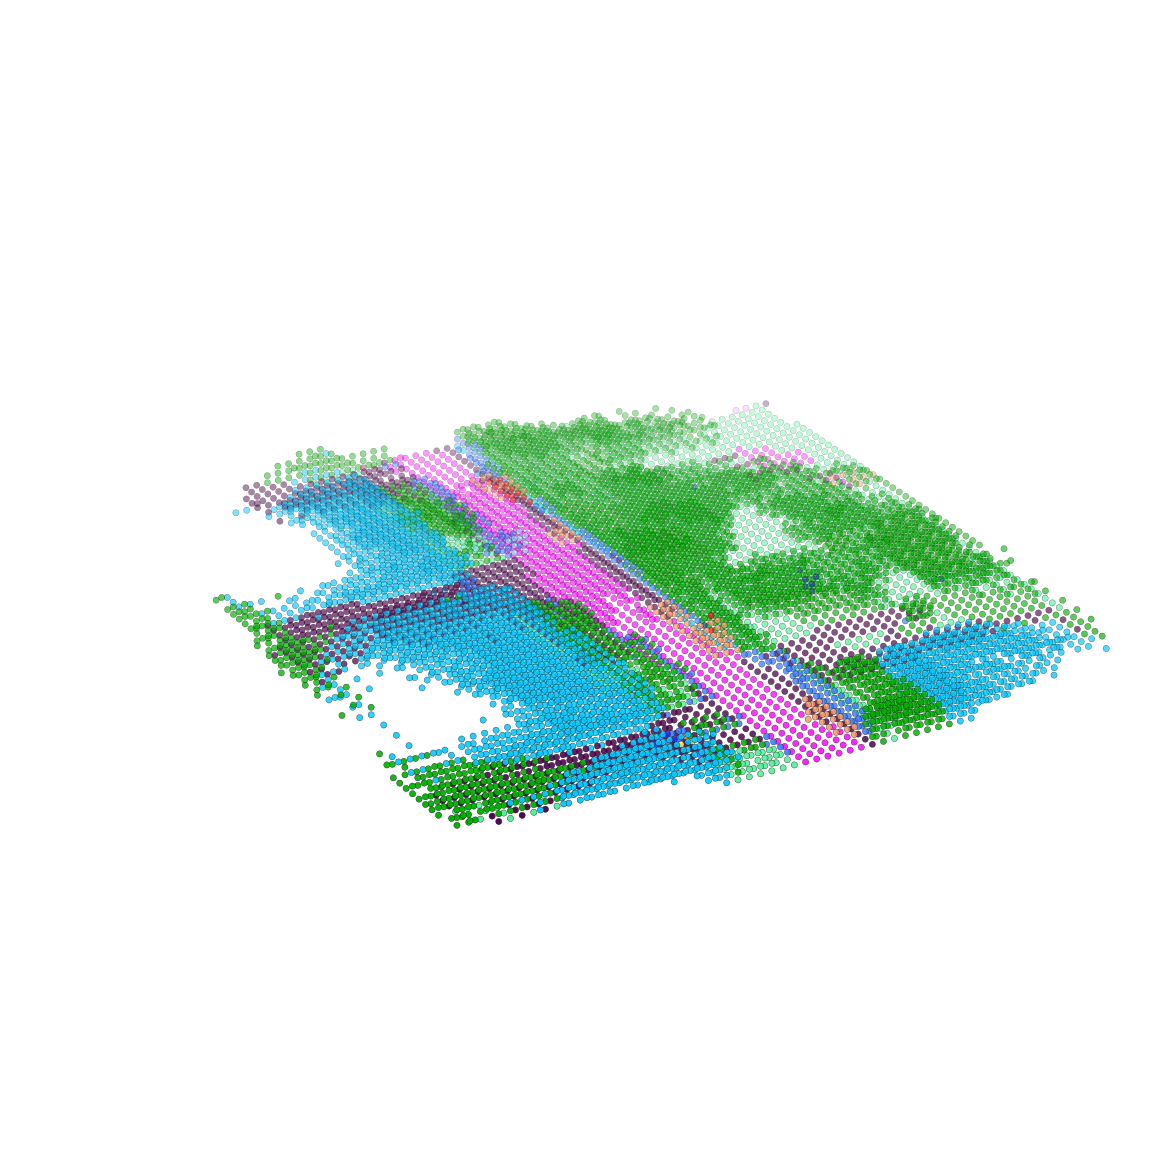

In [74]:
plot_3d_voxels(semantic_prediction, level)

torch.Size([1, 256, 256, 32])
torch.Size([1, 11777, 4])
torch.Size([1, 256, 256, 32])
(1, 256, 256, 32)
[  0   1   6   9  10  11  12  13  14  15  16  17  18  19 255]


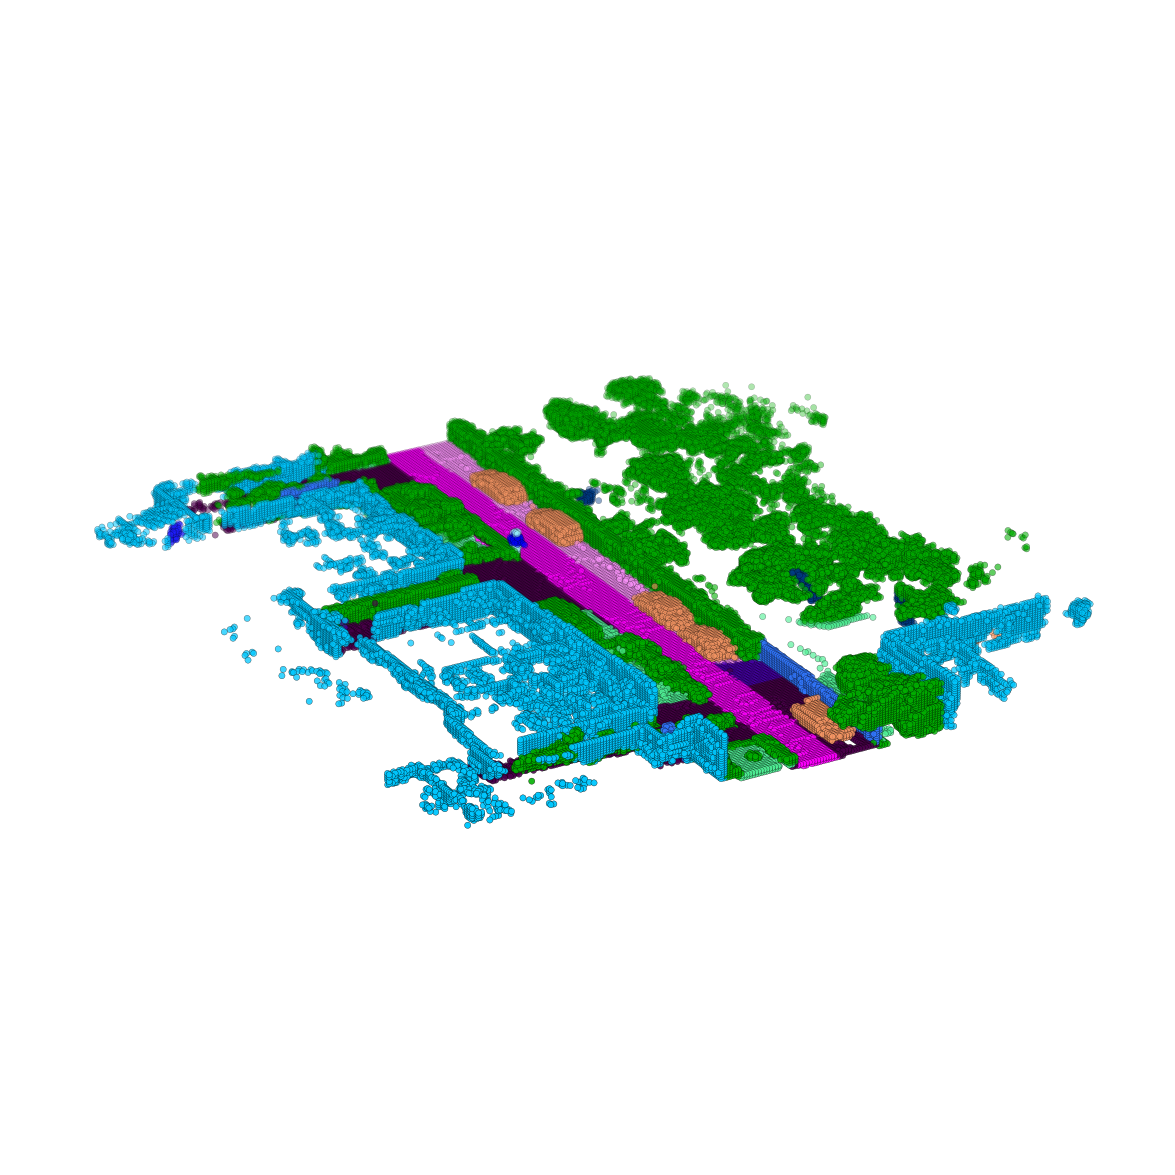

In [63]:
level = "256"
gt_labels = collect(complet_inputs, "complet_labels_{}".format(level))
coords = collect(complet_inputs, "complet_coords".format(level))
valids = collect(complet_inputs, "complet_valid".format(level))


print(gt_labels.shape)
print(coords.shape)
print(valids.shape)

gt_labels = np.uint32(gt_labels.detach().cpu().numpy())
print(gt_labels.shape)
print(np.unique(gt_labels))
plot_3d_voxels(gt_labels[0])

In [64]:
gt_labels = collect(complet_inputs, "complet_labels_{}".format(level)).squeeze()
gt_labels = np.uint32(gt_labels.detach().cpu().numpy())
print(gt_labels.shape)
print(np.unique(gt_labels))
gt_labels[gt_labels==255] = 0

plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(gt_labels, color_map=classes_cmap)
plot += plt_points
plot.display()

(256, 256, 32)
[  0   1   6   9  10  11  12  13  14  15  16  17  18  19 255]


NameError: name 'classes_cmap' is not defined

In [ ]:
train_dataset = SemanticKITTIDataset(config, "train")
train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN.BATCH_SIZE,
        collate_fn=Merge,
        num_workers=config.TRAIN.NUM_WORKERS,
        pin_memory=True,
        shuffle=True,
        drop_last=True,
        worker_init_fn=lambda x: np.random.seed(x + int(time.time()))
    )
training_epoch = 0
# for epoch in range(training_epoch, training_epoch+1):
#     with tqdm(total=len(train_data_loader)) as pbar:
#         for i, batch in enumerate(train_data_loader):
#             print("batch len: ", len(batch))
# #             break
batch = next(iter(train_data_loader))
# labels
# invalid_voxels = batch[1]['complet_invalid']

seg_inputs, complet_inputs, completion_collection, _ = batch
            ## Process seg_inputs with segmentation head
print('\n\n---------------------------------------------------')
print("seg inputs keys: ")

seg_cords = collect(complet_inputs,'seg_coords').squeeze()
seg_features = collect(complet_inputs,'seg_features')
seg_label = collect(complet_inputs,'seg_labels')


# seg_features = seg_inputs['seg_features']
print("seg_cords: type:{}, shape:{}".format(type(seg_cords), seg_cords.shape))
print("seg_cords range: [{},{}]".format(seg_cords.min(),seg_cords.max()))
print("seg_features: type:{}, shape:{}".format(type(seg_features), seg_features.shape))
print("seg_features range: [{},{}]".format(seg_features.min(),seg_features.max()))
print("seg_label: type:{}, shape:{}".format(type(seg_label), seg_label.shape))
print("seg_label range: [{},{}]".format(seg_label.min(),seg_label.max()))

## Process seg_inputs with completion head
print("\ncomplet_inputs keys: ")
complet_coords = collect(complet_inputs, 'complet_coords').squeeze()
complet_invalid = collect(complet_inputs, 'complet_invalid')
complet_label = collect(complet_inputs, 'complet_labels_FULL').squeeze()
complet_occupancy = collect(complet_inputs, 'complet_occupancy_FULL')

# complet_coords = complet_inputs['complet_coords']
# complet_input = complet_inputs['complet_input']
# voxel_centers = complet_inputs['voxel_centers']
# complet_invalid = complet_inputs['complet_invalid']
# complet_label = batch[1]['complet_labels']


print("complete_coords: type:{}, shape:{}".format(type(complet_coords), complet_coords.shape))
print("complete_coords range: [{},{}]".format(complet_coords.min(),complet_coords.max()))
print("complete_label: type:{}, shape:{}".format(type(complet_label), complet_label.shape))
print("complete_label range: [{},{}]".format(complet_label.min(),complet_label.max()))
print("complet_invalid: type:{}, shape:{}".format(type(complet_invalid), complet_invalid.shape))
print("complet_invalid range: [{},{}]".format(complet_invalid.min(),complet_invalid.max()))
# print("complet_input: type:{}, shape:{}".format(type(complet_input), complet_input.shape))
# print("complet_input range: [{},{}]".format(complet_input.min(),complet_input.max()))
print("complet_occupancy: type:{}, shape:{}".format(type(complet_occupancy), complet_occupancy.shape))
print("voxel_centers range: [{},{}]".format(complet_occupancy.min(),complet_occupancy.max()))


print("\ncompletion_collection keys: ", completion_collection.keys())
stat = completion_collection['stat']
print("stat: ",stat)

input2 = completion_collection['input']
print("input2: type:{}, shape:{}".format(type(input2), input2.shape))
print("input2 range: [{},{}]".format(input2.min(),input2.max()))

label = completion_collection['label']
print("label: type:{}, shape:{}".format(type(label), label.shape))
print("label range: [{},{}]".format(label.min(),label.max()))

invalid = completion_collection['invalid']
print("invalid: type:{}, shape:{}".format(type(invalid), invalid.shape))
print("invalid range: [{},{}]".format(invalid.min(),invalid.max()))

occluded = completion_collection['occluded']
print("occluded: type:{}, shape:{}".format(type(occluded), occluded.shape))
print("occluded range: [{},{}]".format(occluded.min(),occluded.max()))
                


## Plot input pointcloud with semantic labels

In [ ]:
import k3d
import numpy as np
seg_coords_np = seg_cords.detach().cpu()[:,:3].numpy()
seg_coords_np = np.float32(seg_coords_np)
seg_aux = seg_cords[:,3]
print(seg_aux.shape)
print(torch.unique(seg_aux))
print(seg_coords_np.shape)
seg_label_np = seg_label.detach().cpu().numpy()
seg_label_np = np.uint32(seg_label_np)
seg_label_np[seg_label_np==4294967196]=20
print(np.unique(seg_label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.points(seg_coords_np, attribute=seg_label_np,point_size=1, shader="dot", color_map=color_map)
# plt_points = k3d.points(seg_coords_np, point_size=0.5, shader="dot", color_map=color_map)

plot += plt_points
plot.display()

## Completion Ground truth with semantic labels

In [8]:
complet_label = collect(complet_inputs, 'complet_labels_FULL').squeeze()
label_np = complet_label.detach().cpu().numpy()
label_np = np.uint32(label_np)
label_np[label_np==255] = 0
print(label_np.shape)
print(np.unique(label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(label_np)
plot += plt_points
plot.display()

complet_label = collect(complet_inputs, 'complet_occupancy_FULL').squeeze()
label_np = complet_label.detach().cpu().numpy()
label_np = np.uint32(label_np)
label_np[label_np==255] = 0
print(label_np.shape)
print(np.unique(label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(label_np)
plot += plt_points
plot.display()

(256, 256, 32)
[ 0  1  9 11 13 14 15 16 17 18]


Output()

(256, 256, 32)
[0 1]


Output()

In [9]:
complet_label = collect(complet_inputs, 'complet_labels_128').squeeze()
print(type(complet_label))
print(complet_label.shape)
label_np = complet_label.detach().cpu().numpy()
label_np = np.uint32(label_np)
# label_np[label_np==255] = 0
print(label_np.shape)
print(np.unique(label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(label_np)
plot += plt_points
plot.display()

complet_label = collect(complet_inputs, 'complet_occupancy_128').squeeze()
print(type(complet_label))
print(complet_label.shape)
label_np = complet_label.detach().cpu().numpy()
label_np = np.uint32(label_np)
# label_np[label_np==255] = 0
print(label_np.shape)
print(np.unique(label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(label_np)
plot += plt_points
plot.display()

<class 'torch.Tensor'>
torch.Size([128, 128, 16])
(128, 128, 16)
[  0   1   9  11  13  14  15  16  17  18 255]


Output()

<class 'torch.Tensor'>
torch.Size([128, 128, 16])
(128, 128, 16)
[0 1]


Output()

In [10]:
complet_label = collect(complet_inputs, 'complet_labels_64').squeeze()
print(type(complet_label))
print(complet_label.shape)
label_np = complet_label.detach().cpu().numpy()
label_np = np.uint32(label_np)
# label_np[label_np==255] = 0
print(label_np.shape)
print(np.unique(label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(label_np)
plot += plt_points
plot.display()

complet_label = collect(complet_inputs, 'complet_occupancy_64').squeeze()
print(type(complet_label))
print(complet_label.shape)
label_np = complet_label.detach().cpu().numpy()
label_np = np.uint32(label_np)
# label_np[label_np==255] = 0
print(label_np.shape)
print(np.unique(label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(label_np)
plot += plt_points
plot.display()

<class 'torch.Tensor'>
torch.Size([64, 64, 8])
(64, 64, 8)
[  0   1   9  11  13  14  15  16  17  18 255]


Output()

<class 'torch.Tensor'>
torch.Size([64, 64, 8])
(64, 64, 8)
[0 1]


Output()

In [8]:
coords = complet_coords.clone()
coords = coords[:, [0, 3, 2, 1]]
coords[:, 3] += 1  # TODO SemanticKITTI will generate [256,256,31]
print(type(coords))
print("complete_coords range: [{},{}]".format(coords[:,0].min(),coords[:,0].max()))
print("complete_coords range: [{},{}]".format(coords[:,1].min(),coords[:,1].max()))
print("complete_coords range: [{},{}]".format(coords[:,2].min(),coords[:,2].max()))
print("complete_coords range: [{},{}]".format(coords[:,3].min(),coords[:,3].max()))
coords_np = coords[:,1:].detach().cpu().numpy()
coords_np = coords_np.astype(int)
voxels = np.zeros((256,256,32))
voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=1
# for c in coords_np:
#     voxels[c[0],c[1],c[2]] = 1

# voxels = np.uint32(voxels)
print(voxels.shape)
print(np.unique(voxels))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(voxels)
plot += plt_points
plot.display()


<class 'torch.Tensor'>
complete_coords range: [0.0,0.0]
complete_coords range: [0.0,255.0]
complete_coords range: [97.0,236.0]
complete_coords range: [1.0,20.0]
(256, 256, 32)
[0. 1.]


/usr/local/lib/python3.8/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "uint8". A coerced copy has been created.
  warnings.warn(


Output()

In [15]:
label_np = label[0].detach().cpu().numpy()
label_np = np.uint32(label_np)
print(label_np.shape)
print(np.unique(label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(label_np)
plot += plt_points
plot.display()

(256, 256, 32)
[  0   1   9  11  13  14  15  17  18 255]


Output()

## Input voxels

## Checking if created coordinates correspond to the same input voxel representation

In [6]:
coords = complet_coords.clone()
coords = coords[:, [0, 3, 2, 1]]
coords[:, 3] += 1  # TODO SemanticKITTI will generate [256,256,31]
print(type(coords))
print("complete_coords range: [{},{}]".format(coords[:,0].min(),coords[:,0].max()))
print("complete_coords range: [{},{}]".format(coords[:,1].min(),coords[:,1].max()))
print("complete_coords range: [{},{}]".format(coords[:,2].min(),coords[:,2].max()))
print("complete_coords range: [{},{}]".format(coords[:,3].min(),coords[:,3].max()))
coords_np = coords[:,1:].detach().cpu().numpy()
coords_np = coords_np.astype(int)
voxels = np.zeros((256,256,32))
voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=1
# for c in coords_np:
#     voxels[c[0],c[1],c[2]] = 1


<class 'torch.Tensor'>
complete_coords range: [0.0,0.0]
complete_coords range: [0.0,255.0]
complete_coords range: [52.0,233.0]
complete_coords range: [1.0,20.0]


In [8]:
# voxels = np.uint32(voxels)
print(voxels.shape)
print(np.unique(voxels))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(voxels)
plot += plt_points
plot.display()

(256, 256, 32)
[0. 1.]


Output()

## Filter out invalid voxels

In [9]:
invalid_locs = torch.nonzero(invalid[0])
occluded_locs = torch.nonzero(occluded[0])

print(invalid_locs.shape)
label_no_invalid = label[0].clone()
label_no_invalid[invalid_locs[:,0], invalid_locs[:,1], invalid_locs[:,2]] = 255
label_np = label_no_invalid.detach().cpu().numpy()
label_np = np.uint32(label_np)
print(label_np.shape)
print(np.unique(label_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(label_np)
plot += plt_points
plot.display()

torch.Size([531780, 3])
(256, 256, 32)
[  0   1   5   8   9  10  11  13  14  15  16  18  19 255]


Output()

In [11]:

# occluded_np = occluded[0].detach().cpu().numpy()
# occluded_np = np.uint32(occluded_np)
# print(occluded_np.shape)
# print(np.unique(occluded_np))
# plot = k3d.plot(camera_auto_fit=True)
# plt_points = k3d.voxels(occluded_np)
# plot += plt_points
# plot.display()

invalid_np = invalid[0].detach().cpu().numpy()
invalid_np = np.uint32(invalid_np)
print(invalid_np.shape)
print(np.unique(invalid_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.voxels(invalid_np)
plot += plt_points
plot.display()

(256, 256, 32)
[0 1]


Output()